### Word2Vec
It is a model used for learning vector representation of words called "word embeddings".It takes a text corpus and produces a vector set as the output for each unique ocurrence of the words in the dataset. The vectors correspond to each word and are of length 100 each.

#### Run the following to download the packages

In [0]:
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

#### Run the following to load performance metrics

In [0]:
# pip install keras-metrics

In [3]:
# Required Libraries
import gensim 
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import keras_metrics
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.collocations import *
from nltk.stem import WordNetLemmatizer

Using TensorFlow backend.


#### Load the dataset from the csv files
* Training : P1_training_set.csv
* Testing : P1_testing_set.csv
Create a collective dataset (df) - to perform pre-processing uniformly on the dataset

In [0]:
df_train_org = pd.read_csv("P1_training_set.csv")
df_train_shuf = shuffle(df_train_org)

df_test_org = pd.read_csv("P1_testing_set.csv")
df_test_shuf = shuffle(df_test_org)

frames = [df_train_shuf, df_test_shuf]
df = pd.concat(frames, axis=0)

### Preprocessing
* Word Tokenize : Convert the sentences into Tokens
* Use the stopwords and punctuation list from nltk to clean the word tokens
* Use WordNetLemmatizer to convert words to their base form

In [0]:
def preprocessing(text):
    sent = ''.join(i for i in text if not i.isdigit())
    word_sent = word_tokenize(sent)
    _stopwords = set(stopwords.words('english') + list(punctuation))
    st = WordNetLemmatizer() 
    _stopwords.add("'s")
    word_sent = [st.lemmatize(word) for word in word_sent if word not in _stopwords]
    return word_sent

for i in df:
    df['process_E1'] = [preprocessing(i) for i in df['Event 1']]
    df['process_E2'] = [preprocessing(i) for i in df['Event 2']] 

#### Train the word2vec model on the given dataset

In [0]:
# !wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz" 
# from gensim.models import KeyedVectors
# EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
# model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

model = gensim.models.Word2Vec(df['process_E1']+df['process_E2'], min_count = 1,size = 100, window = 5) 


### Word Embedding
Convert the word tokens into vectors each of length 100.

In [7]:
list_E1 = []
for j in df['process_E1']:
  res = sum(np.array(model[j]))
  val = res/len(j)
  list_E1.append(val)

list_E2 = []
for j in df['process_E2']:
  res = sum(np.array(model[j]))
  val = res/len(j)
  list_E2.append(val)

event_concat = list(map(lambda x, y: list(x) + list(y), list_E1, list_E2))
df_vec = pd.DataFrame(list(zip(list_E1, list_E2, event_concat, df['Label'])),columns = ['List_E1', 'List_E2', 'Total Event','Label'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


### Input and Output Dataset
df_vec['Total Event'] - X : Input

df_vec['Label'] - Y : Output

Training : 70% of the Dataset

Testing : 30% of the Dataset

In [0]:
X = df_vec['Total Event']
y = df_vec['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30, random_state=42)					 
X_train = sequence.pad_sequences(X_train)
X_test = sequence.pad_sequences(X_test)

### Model 1
- Sequential Model
- 100 units - LSTM
- Dense Layer - 1 hidden unit with "sigmoid" activation function
- Dense Layer - 1 hidden unit with "softmax" activation function
- Optimizer - "rmsprop"

In [9]:
embedding_vecor_length = 32
model1 = Sequential()
model1.add(Embedding(10000, 500, input_length=200))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))
model1.add(Dense(1, activation="softmax"))
model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

print(model1.summary())

# Training Phase - Fit the model
model1.fit(X_train, y_train, epochs=3, batch_size=64)

# Testing Phase - Evaluate the model
scores = model1.evaluate(X_test, y_test, verbose=0)

# Performance Metrics
print('Accuracy   : {:2.3}'.format(scores[1]))
print('Precision  : {:2.3}'.format(scores[2]))
print('Recall     : {:2.3}'.format(scores[3]))
print('Loss       : {:2.3}'.format(scores[0]))
f_score = (2.0 * scores[2] * scores[3]) / (scores[2] + scores[3])
print('F1-Score   : {:2.3}'.format(f_score))






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 500)          5000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               240400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 5,240,503
Trainable params: 5,240,503
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
6276/6276 [==============================] - 41s 6ms/step - loss: -2.6952 - acc: 0.3921 - precision: 1.1691 - recall: 1.0000
Ep

### Model 2
* Sequential Model
* 100 units - LSTM
* Dense Layer - 256 hidden unit with - "relu" activation function
* Dense Layer - 1 hidden unit with - - "softmax" activation function
* Optimizer - "adam"

In [10]:
embedding_vecor_length = 26
model2 = Sequential()
model2.add(Embedding(10000, 500, input_length=200))
model2.add(LSTM(100))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation="softmax"))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

print(model2.summary())
model2.fit(X_train, y_train, epochs=3, batch_size=64)

# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=0)

print('Accuracy   : {:2.3}'.format(scores[1]))
print('Precision  : {:2.3}'.format(scores[2]))
print('Recall     : {:2.3}'.format(scores[3]))
print('Loss       : {:2.3}'.format(scores[0]))
f_score = (2.0 * scores[2] * scores[3]) / (scores[2] + scores[3])
print('F1-Score   : {:2.3}'.format(f_score))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 500)          5000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               240400    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 5,266,513
Trainable params: 5,266,513
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
6276/6276 [==============================] - 40s 6ms/step - loss: -2.6952 - acc: 0.3921 - precision: 1.1691 - recall: 1.0000
Epoch 2/3
6276/6276 [==============================] - 40s 6ms/step - loss: -2.6952 - acc: 0.3921 - pr

### Model 3
- Linear SVC - Linear Support Vector Classification
- random state = 0
- Tolerance for stopping criteria - e-5

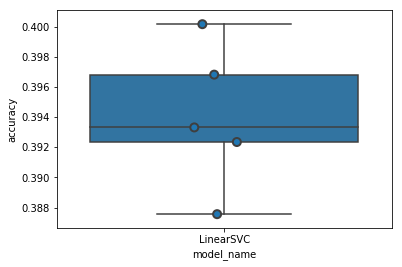

In [11]:
models = [LinearSVC(random_state=0, tol=1e-5)]
CV = 5
cv_df = pd.DataFrame(index=range(len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [12]:
val = 0
for i in range(len(cv_df)):
  val  = val + cv_df['accuracy'][i]
val = val/5
print("---------------------")
print(cv_df['model_name'][i],'  Accuracy : {:2.3}%'.format(val* 100))
print('---------------------')

---------------------
LinearSVC   Accuracy : 39.4%
---------------------


### Performance Metrics

Environment : Google Colabs - GPU

#### Model 1 - Sequential - LSTM(100),Sigmod(1), Softmax(1)
* Accuracy   : 41.9%
* Precision  : 1.15
* Recall     : 1.0
* Loss       : -2.32
* F1-Score   : 1.07
##### Computation time : 2 mins

#### Model 2 - Sequential - LSTM(100),Relu(256), Softmax(1)
* Accuracy   : 42%
* Precision  : 1.15
* Recall     : 1.0
* Loss       : -2.32
* F1-Score   : 1.07

##### Computation time : 2 mins

#### Model 3 - Linear Support Vector Classifier
* Accuracy  : 39.4%